# Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import re
from plotting import plot_stations_matplotlib
# from processAllData import getAllReadyForStationByLatAndLongAndK, getAllReadyForStationByLatAndLongAndKSplitTestAndTrain

#from LSTMArchitecture import GHIDataset, Main_LSTM
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import glob # For loading multiple files
#import random
import os
import torch.optim as optim
from tqdm import tqdm

# Functions

In [10]:

def getStationTimePeriodFromYears(csv_file):
  match = re.search(r'(\d{4})-(\d{4})', csv_file)
  if match:
    start_year = int(match.group(1))
    end_year = int(match.group(2))
    #print(start_year, end_year)  # Output: 2005 2017
    return (start_year, end_year)
  

def denormalizeHourOrMonth(anglesin, anglecos, cycleLength):
  angle = np.arctan2(anglesin, anglecos)
  cycleBeforeModulo = (angle / (2 * np.pi)) * cycleLength + 1
  return (cycleBeforeModulo % cycleLength)


# Euclidean distance function
def euclidean_distance(lat1, lon1, lat2, lon2):
    distance_vector = ((lat2 - lat1), lon2 - lon1)
    return ((np.sqrt((lat2 - lat1)**2) + (lon2 - lon1)**2), distance_vector)

# Function to find the K nearest stations (not returning nearest station given)
def find_k_nearest_stations(df, station_name, k):
    if station_name not in df['station'].values:
        return f"Station {station_name} not found in the dataset."

    # Get the coordinates of the given station
    station_coords = df[df['station'] == station_name][['Latitude', 'Longitude']].values[0]
    lat1, lon1 = station_coords

    # Calculate the distance from the given station to all other stations
    df['distance'] = df.apply(lambda row: euclidean_distance(lat1, lon1, row['Latitude'], row['Longitude']), axis=1)

    # station_coords = df[df['station'] == station_name][['norm_lat', 'norm_long']].values[0]
    # lat1, lon1 = station_coords

    # # Calculate the distance from the given station to all other stations
    # df['distance'] = df.apply(lambda row: euclidean_distance(lat1, lon1, row['norm_lat'], row['norm_long']), axis=1)

    # Sort the DataFrame by distance and get the K nearest stations
    #nearest_stations = df[df['station'] != station_name].sort_values(by='distance').head(k)
    nearest_stations = df[df['station'] != station_name].sort_values(by='distance', key=lambda x: x.apply(lambda y: y[0])).head(k)

    return nearest_stations[['station', 'norm_lat', 'norm_long', 'distance', 'StartTime', 'EndTime']]


def latlon_to_xy(lat, lon, lat0):
    """Simple equirectangular projection."""
    R = 6371  # radius in km
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return x, y

def compute_angle(vec1, vec2):
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0  # Could return np.pi to maximize diversity if desired
    unit1 = vec1 / norm1
    unit2 = vec2 / norm2
    return np.arccos(np.clip(np.dot(unit1, unit2), -1.0, 1.0))

def makeDistanceTuple(distance, x, y):
  return (distance, (x,y))

def spatially_diverse_knn(df,station_name, k=3, candidate_pool=78):
  # spatially_diverse_knn_df
  #
  # This function selects the 'k' nearest stations to a given target station,
  # while ensuring that the selected neighbors are spatially diverse. Instead
  # of simply choosing the closest stations, it incorporates an angular diversity
  # criterion that selects stations spread out in different directions. This helps
  # avoid picking stations that are clustered in one region around the target.
  #
  # Parameters:
  #   - df: DataFrame containing station information (latitude, longitude, station_name)
  #   - center_latlon: Coordinates (latitude, longitude) of the target station
  #   - k: Number of neighbors to select (default is 3)
  #   - candidate_pool: Number of candidates to consider before selection (default is len(csv_files)=78)
  #
  # Returns:
  #   - A DataFrame with 'k' stations selected based on spatial diversity from the target
    # Exclude the center point if it exists in the set
    if station_name not in df['station'].values:
      return f"Station {station_name} not found in the dataset."

    center_latlon = df[df['station'] == station_name][['Latitude', 'Longitude']].values[0]
    mask = ~((df['Latitude'] == center_latlon[0]) & (df['Longitude'] == center_latlon[1]))
    df_filtered = df[mask].copy()
    #df_filtered['distance_vector'] = [(0.0, (0.0, 0.0))] * len(df_filtered)  # Initialize with default values

    # Convert to x/y coords
    lat0 = center_latlon[0]
    df_filtered['x'], df_filtered['y'] = latlon_to_xy(df_filtered['Latitude'], df_filtered['Longitude'], lat0)
    center_x, center_y = latlon_to_xy(center_latlon[0], center_latlon[1], lat0)
    center_xy = np.array([center_x, center_y])

    # Compute distances
    df_filtered['distance'] = np.linalg.norm(df_filtered[['x', 'y']].values - center_xy, axis=1)
    df_sorted = df_filtered.sort_values('distance').head(candidate_pool)
    df_sorted['distance'] = df_sorted.apply(lambda row: makeDistanceTuple(row['distance'], row['x'], row['y']), axis=1)
    selected_rows = []
    selected_xy = []

    for idx, row in df_sorted.iterrows():
        cand_xy = np.array([row['distance'][1][0], row['distance'][1][1]])
        if len(selected_xy) == 0: #gets closest station
            selected_rows.append(row)
            selected_xy.append(cand_xy)
        else:
            angles = [compute_angle(cand_xy - center_xy, s - center_xy) for s in selected_xy]
            min_angle = min(angles)
            if min_angle > np.radians(45) or len(selected_xy) < k // 2:
                selected_rows.append(row)
                selected_xy.append(cand_xy)
        if len(selected_rows) == k:
            break

    # selectedStations = pd.DataFrame(selected_rows).drop(columns=['x', 'y']).reset_index(drop=True)
    # selectedStations.rename(columns= {'distance_vector': 'distance'}, inplace=True)
    return pd.DataFrame(selected_rows).drop(columns=['x', 'y']).reset_index(drop=True), center_latlon

def find_nearest_station_given_long_lat(df,Longitude, Latitude):
    # Find the station with the smallest Euclidean distance to the given coordinates
    df['distance'] = df.apply(lambda row: euclidean_distance(Latitude, Longitude, row['Latitude'], row['Longitude']), axis=1)
    nearest_station = df.sort_values(by='distance', key=lambda x: x.apply(lambda y: y[0])).head(1)
    return nearest_station[['station', 'Latitude', 'Longitude', 'distance', 'StartTime', 'EndTime']]

    #To get station name print(str(wanted_station.station.iloc[0]))

def find_nearest_station_given_normed_long_lat(df,Longitude_Normed, Latitude_Normed):
    # Find the station with the smallest Euclidean distance to the given coordinates
    df['distance'] = df.apply(lambda row: euclidean_distance(Longitude_Normed, Latitude_Normed, row['norm_lat'], row['norm_long']), axis=1)
    nearest_station = df.sort_values(by='distance', key=lambda x: x.apply(lambda y: y[0])).head(1)
    return nearest_station[['station', 'norm_lat', 'norm_long', 'distance', 'StartTime', 'EndTime']]

    #To get station name print(str(wanted_station.station.iloc[0]))

def modify_nearest_stations(nearest_stations):
    modified_nearest_stations = []
    for station in nearest_stations['station']:
        modified_station = station.replace(" ", "-")
        modified_nearest_stations.append(modified_station)
    return modified_nearest_stations

def find_stations_csv(stations, csvs):
    station_order = []
    nearest_stations_csvs = []
    for station in stations:
        for csv in csvs:
            if station.lower() in csv.lower():
                nearest_stations_csvs.append(csv)
                print(f"Station {station} found in {csv}")
                station_order.append(station)
                break
    return nearest_stations_csvs, station_order

def adjustWindDirection(wind_direction_degress, theta_relative):
#Adjusts auxillary stations wind direction to be relative to the wanted stations position
  # Adjust the wind direction by subtracting the relative angle
  adjusted_wind_direction = wind_direction_degress - theta_relative
  # Normalize to 0-360 degrees
  adjusted_wind_direction = (adjusted_wind_direction + 360) % 360
  return adjusted_wind_direction

def cyclicalEncoding(data, cycleLength):
  newDatasin = np.sin(2 * np.pi * (data - 1) / cycleLength)  # Sine encoding for hours (adjust for 0-23)
  newDatacos = np.cos(2 * np.pi * (data - 1) / cycleLength)  # Cosine encoding for hours (adjust for 0-23)
  return newDatasin, newDatacos

usecols = [
    'Year Month Day Hour (YYYYMMDDHH)',
    'Global horizontal irradiance / kJ/m2',
    'Direct normal irradiance / kJ/m2',
    'Diffuse horizontal irradiance / kJ/m2',
    'Wind direction / 0-359 degrees',
    'Wind speed / 0.1 m/s'
]

dtype = {
    'Year Month Day Hour (YYYYMMDDHH)': str,  # Read as string initially to handle errors
    'Global horizontal irradiance / kJ/m2': str,
    'Direct normal irradiance / kJ/m2': str,
    'Diffuse horizontal irradiance / kJ/m2': str,
    'Wind direction / 0-359 degrees': str,
    'Wind speed / 0.1 m/s': str
}

def get_nearest_stations_data(nearest_stations_csvs, min_start_year, max_end_year, wantedStationCSV=False, RelativeAnglesDegrees=[(0,0)]):
    dfs = []
    i = 0
    meanGHI = 0
    stdGHI = 0
    for f in nearest_stations_csvs:
      # Read the CSV file with specified columns and data types
      df = pd.read_csv(f, delimiter=',', skiprows=2, index_col=False, usecols=usecols, dtype=dtype, on_bad_lines='skip')
      # Convert columns to numeric, coercing errors to NaN
      for col in usecols:
          if(col == 'Year Month Day Hour (YYYYMMDDHH)'):
              #keep as string
              df['Year Month Day Hour (YYYYMMDDHH)'] = df[col].astype(int)
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']>min_start_year]
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']<=max_end_year]#Data is between min_start_year and max_end_year to accomidate files that dont have the same amount of data

              if(wantedStationCSV): #get month and hour for just wanted station
                  df['Year Month Day Hour (YYYYMMDDHH)'] = df['Year Month Day Hour (YYYYMMDDHH)'].astype(str)
                  # Get month (1-12)
                  df['Month'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[4:6].astype(int)
                  # Get hour (1-24)
                  df['Hour'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[8:10].astype(int)
                  # Normalize hour so cyclic (0-23)
                  df['Hour_sin'], df['Hour_cos'] = cyclicalEncoding(df['Hour'], 24)# Sine and Cosine encoding for hours (adjust for 0-23)
                  # df['Hour_sin'] = np.sin(2 * np.pi * (df['Hour'] - 1) / 24)
                  # df['Hour_cos'] = np.cos(2 * np.pi * (df['Hour'] - 1) / 24)  # Cosine encoding for hours (adjust for 0-23)
                  # Normalize month so cyclic (0-11))
                  df['Month_sin'], df['Month_cos'] = cyclicalEncoding(df['Month'], 12)# Sine and Cosine encoding for months
                  # df['Month_sin'] = np.sin(2 * np.pi *  (df['Month']-1)/ 12)  # Sine encoding for months
                  # df['Month_cos'] = np.cos(2 * np.pi *  (df['Month']-1) / 12)  # Cosine encoding for months
                  df = df.drop(columns=['Month'], axis=1)
                  df = df.drop(columns=['Hour'], axis=1)

              df = df.drop(columns=[col], axis=1)
              continue

          if(col=='Wind direction / 0-359 degrees'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              if(not wantedStationCSV):
                df[col] = df[col].apply(lambda x: adjustWindDirection(x, RelativeAnglesDegrees[i]))
                #When wind is pointed towards the wanted station it has a new angle of 0 degrees and when pointed directly away from it it has a 180 degrees value now
              radians = np.deg2rad(df[col])
              df['wind_dir_sin'] = np.sin(radians)
              df['wind_dir_cos'] = np.cos(radians)
              df = df.drop(columns=[col], axis=1)
              continue

          if(col == 'Wind speed / 0.1 m/s'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              mean = df[col].mean()
              std = df[col].std()
              df[col] = (df[col] - mean) / std
              continue

          if (col == 'Global horizontal irradiance / kJ/m2' or col == 'Direct normal irradiance / kJ/m2' or col == 'Diffuse horizontal irradiance / kJ/m2'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(9999, np.nan)
              mean = df[col].mean()
              std = df[col].std()
              df[col] = (df[col] - mean) / std #can denormalize output
              if (col == 'Global horizontal irradiance / kJ/m2'):
                meanGHI = mean
                stdGHI = std #for denormalizing
              continue
          df[col] = pd.to_numeric(df[col], errors='coerce')
      df.fillna(0, inplace=True)
      dfs.append(df)
      i+=1
      #print(df.columns)
    return dfs, meanGHI, stdGHI

def chunk(df, interval = 25):
    results = []
    for i in range(0, len(df)-interval, 1):
        chunk = df[i:i+interval]
        results.append(chunk)
    results = np.array(results)
    return results

def get_chunked_tensors(nearest_stations, dfs, interval):
  chunked_tensors = []
  rows = 0
  station_order = []
  for index, station in nearest_stations.iterrows():
    distanceVector = station.iloc[3][1]
    chunked_df = chunk(dfs[rows], interval=interval)
    rows+=1
    chunkedTensor = torch.tensor(chunked_df).to(torch.float32)
    chunked_tensors.append(chunkedTensor)
    station_order.append(station)
  return chunked_tensors, station_order


def getMaxStartMinEndYearComplete(max_start_year, min_end_year):
  maxStartYear, minEndYear = str(max_start_year), str(min_end_year)
  #print(max_start_year, min_end_year)
  maxStartYear = maxStartYear+"010100"
  minEndYear = minEndYear+"123124"
  maxStartYear = int(maxStartYear)
  minEndYear = int(minEndYear)
  return maxStartYear, minEndYear

def angle_from_wanted_station(row, wanted_station_long, wanted_station_lat):
	print(row["station"])
	lat, lon = row['Latitude'], row['Longitude']
	delta_lon = lon - wanted_station_long
	delta_lat = lat - wanted_station_lat
	angle = np.arctan2(delta_lat, delta_lon)  # Angle in radians
	angle_degrees = np.degrees(angle)
	if angle_degrees < 0:
			angle_degrees += 360  # Normalize to [0, 360]
	return angle_degrees

def sortAuxillaryStations(nearest_stations_df, wanted_station_lat, wanted_station_long):
    """
    From the auxillary stations found, sort them to have the first one be the eastern most station, the second be the western most station the third be the northern most station and the fourth be the southern most station
    """

    nearest_stations_df['angle'] = nearest_stations_df.apply(angle_from_wanted_station, axis=1, wanted_station_long=wanted_station_long, wanted_station_lat=wanted_station_lat)
    sorted_stations = nearest_stations_df.sort_values(by='angle').reset_index(drop=True)
    print("Sorted Stations by angle (0 degrees is east, 90 degrees is north, 180 degrees is west, 270 degrees is south):")
    print(sorted_stations.head())
    return sorted_stations
  

def getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, min_start_year, max_end_year, RelativeAnglesDegrees, csv_files):
  #doing all thats needed to get Auxillary stations data ready and in chunked tensors and in order chunked
  modified_nearest_stations = modify_nearest_stations(nearest_stations)
  nearest_stations_csvs, station_order = find_stations_csv(modified_nearest_stations, csv_files)
  nearest_stations_data_dfs, _, _ = get_nearest_stations_data(nearest_stations_csvs, min_start_year, max_end_year, False, RelativeAnglesDegrees)

  for i in range(k):
    nearest_stations_data_dfs[i]["distanceX"] = [nearest_stations['distance'].values[i][1][0]]*len(nearest_stations_data_dfs[i])
    nearest_stations_data_dfs[i]["distanceY"] = [nearest_stations['distance'].values[i][1][1]]*len(nearest_stations_data_dfs[i])
    #print(nearest_stations_data_dfs[i].head())
    #print(nearest_stations_data_dfs[i].columns)
  aux_chunked_tensors, aux_chunked_station_order = get_chunked_tensors(nearest_stations, nearest_stations_data_dfs, 25)
  return aux_chunked_tensors, aux_chunked_station_order


def getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf, lat, long, k, csv_files):
  #doing everything needed to get wanted stations data ready and in chunked tensors as well as get wanted station and its name
  wanted_station = find_nearest_station_given_long_lat(stationsName_lat_long_datadf, lat, long)
  max_start_year = wanted_station["StartTime"].values[0]
  min_end_year = wanted_station["EndTime"].values[0]

  wanted_station.at[wanted_station.index[0], "distance"] = (0.0, (0.0, 0.0))
  wanted_station_modified = modify_nearest_stations({"station": wanted_station["station"]})
  wanted_station_csv, _ = find_stations_csv(wanted_station_modified, csv_files)

  nearest_stations, target_point = spatially_diverse_knn(stationsName_lat_long_datadf, wanted_station["station"].values[0], k)
  #print("nearest: ", nearest_stations.head())
  #print("wanted: ", wanted_station)
  nearest_stations = sortAuxillaryStations(nearest_stations, wanted_station["Latitude"].values[0], wanted_station["Longitude"].values[0])
  plot_stations_matplotlib(target_point, nearest_stations, stationsName_lat_long_datadf)
  max_start_year, min_end_year = max(max_start_year, *nearest_stations["StartTime"].values), min(min_end_year, *nearest_stations["EndTime"].values)
  max_start_year, min_end_year = getMaxStartMinEndYearComplete(max_start_year, min_end_year)

  RelativeAnglesDegrees = []
  for distanceVector in nearest_stations["distance"].values:
    Relative_Angle_Radians = np.arctan2(distanceVector[1][1], distanceVector[1][0])#Relative Distance Vector y and Distance Vector x
    Relative_Angle_Degrees = np.degrees(Relative_Angle_Radians)
    if Relative_Angle_Degrees < 0:
      Relative_Angle_Degrees += 360
    RelativeAnglesDegrees.append(Relative_Angle_Degrees)

  aux_chunked_tensors, aux_chunked_station_order = getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, max_start_year, min_end_year, RelativeAnglesDegrees, csv_files)

  wanted_station_data_dfs, meanGHI, stdGHI = get_nearest_stations_data(wanted_station_csv, max_start_year, min_end_year,wantedStationCSV=True)
  #print(wanted_station_data_dfs[0].head())
  wanted_chunked_tensors, _ = get_chunked_tensors(wanted_station, wanted_station_data_dfs, 25)

  return wanted_chunked_tensors, wanted_station["station"].values[0], aux_chunked_tensors, aux_chunked_station_order, meanGHI, stdGHI


def getAllReadyForStationByLatAndLongAndKSplitTestAndTrain(stationsName_lat_long_datadf, lat, long, k, csv_files):
  #doing everything needed to get wanted stations data ready and in chunked tensors as well as get wanted station and its name
  wanted_station = find_nearest_station_given_long_lat(stationsName_lat_long_datadf, lat, long)
  max_start_year = wanted_station["StartTime"].values[0]
  min_end_year = wanted_station["EndTime"].values[0]

  wanted_station.at[wanted_station.index[0], "distance"] = (0.0, (0.0, 0.0))
  wanted_station_modified = modify_nearest_stations({"station": wanted_station["station"]})
  wanted_station_csv, _ = find_stations_csv(wanted_station_modified, csv_files)

  nearest_stations, target_point = spatially_diverse_knn(stationsName_lat_long_datadf, wanted_station["station"].values[0], k)
  #plot_stations_matplotlib(target_point, nearest_stations, stationsName_lat_long_datadf)
  max_start_year, min_end_year = max(max_start_year, *nearest_stations["StartTime"].values), min(min_end_year, *nearest_stations["EndTime"].values)#Get earliest year that all start at (max_start_year) and latest year all go until (min_end_year)
  train_max_start_year, train_min_end_year = getMaxStartMinEndYearComplete(max_start_year, min_end_year-2)
  test_max_start_year, test_min_end_year = getMaxStartMinEndYearComplete(min_end_year-1, min_end_year)

  print(max_start_year,min_end_year)
  print(train_max_start_year, train_min_end_year)
  print(test_max_start_year, test_min_end_year)

  RelativeAnglesDegrees = []
  for distanceVector in nearest_stations["distance"].values:
    Relative_Angle_Radians = np.arctan2(distanceVector[1][1], distanceVector[1][0])#Relative Distance Vector y and Distance Vector x
    Relative_Angle_Degrees = np.degrees(Relative_Angle_Radians)
    if Relative_Angle_Degrees < 0:
      Relative_Angle_Degrees += 360
    RelativeAnglesDegrees.append(Relative_Angle_Degrees)

  trainSet_aux_chunked_tensors, trainSet_aux_chunked_station_order = getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, train_max_start_year, train_min_end_year, RelativeAnglesDegrees, csv_files)
  testSet_aux_chunked_tensors, testSet_aux_chunked_station_order = getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, test_max_start_year, test_min_end_year, RelativeAnglesDegrees, csv_files)

  trainSet_wanted_station_data_dfs = get_nearest_stations_data(wanted_station_csv, train_max_start_year, train_min_end_year,wantedStationCSV=True)
  testSet_wanted_station_data_dfs = get_nearest_stations_data(wanted_station_csv, test_max_start_year, test_min_end_year,wantedStationCSV=True)
  #print(wanted_station_data_dfs[0].head())

  trainSet_wanted_chunked_tensors, _ = get_chunked_tensors(wanted_station, trainSet_wanted_station_data_dfs, 25)
  testSet_wanted_chunked_tensors, _ = get_chunked_tensors(wanted_station, testSet_wanted_station_data_dfs, 25)

  return trainSet_wanted_chunked_tensors, testSet_wanted_chunked_tensors, wanted_station["station"].values[0], trainSet_aux_chunked_tensors, testSet_aux_chunked_tensors, trainSet_aux_chunked_station_order, testSet_aux_chunked_station_order

In [11]:
def test_model(model, test_loader, criterion, device):
    # if(combined_test_chunked_data_tensor.shape):
    #   dataset = GHIDataset(combined_test_chunked_data_tensor, device=device)
    #   train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    # dataset = GHIDataset(combined_chunked_data_tensor, device=device)
    # train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model.eval()
    outputlist = []
    targetData=[]
    colourList = []
    for inputs, targets in test_loader:
        output = model(inputs)
        colourList.append(inputs[:,-1].detach().cpu().numpy())#Saving hour before predicted hour
        targetData.append(targets.detach().cpu().numpy())
        outputlist.append(output.detach().cpu().numpy())
    colourList = np.concatenate(colourList[:-1], axis=0)#Last batch size is too small so getting rid of it with the -1
    outputlist = np.concatenate(outputlist[:-1], axis=0)
    targetData = np.concatenate(targetData[:-1], axis=0)
    #del combined_chunked_data_tensor #Saving RAM space
    return outputlist, targetData, colourList

# Model Architecture

In [12]:
class GHIDataset(Dataset):
    def __init__(self, chunked_data, device='cuda'):
        super(GHIDataset, self).__init__()
        self.chunked_data = chunked_data.to(device) #chunked data needs to be passed in as a tensor
        self.device = device

    def __len__(self):
        return len(self.chunked_data)

    def __getitem__(self, i):
        element = self.chunked_data[i] #need to break down to zeroth element of list and first element of that is GHI of that which is the target
        # inputs = []
        # for el in element:
        #   inputs.append(el[0:-1])
        #print(element.shape)
        return element[0:-1], element[-1,0] #ensure first station in dataset is the one we are wanting to predict
    

class Main_LSTM(nn.Module):
    def __init__(self, dropout=0.0):
        """
        input_dim: Number of features per time step (here, 5)
        hidden_dim: Number of hidden units in the LSTM
        num_layers: Number of stacked LSTM layers
        dropout: Dropout probability (applied between LSTM layers if num_layers > 1)
        """
        super(Main_LSTM, self).__init__()
        self.Stationlstm = nn.LSTM(34, 128, 3,
                            batch_first=True, dropout=dropout)
        self.Auxlstm = nn.LSTM(8, 8, 2,
                            batch_first=True, dropout=dropout)#may need to change 16 back to 8
        # A fully-connected layer to map the LSTM output to a single GHI prediction
        self.station_fc = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        # LSTM returns output for every time step, and the final hidden and cell states.

        #torch.Size([32, 24, 64])
        main_station_data = x[:, :, :10]  # First 10 features are for main station
        aux_station_data = x[:, :, 10:]  # Remaining features are for auxiliary stations
        aux_lstm_outs = []
        #other idea: range start at 10 go to 34 add 8 each time as 3 auxillaries
        for i in range(0, 24, 8): #range start at 0 go to 24 add 8 each time as 3 auxillary stations
          lstm_out, _ = self.Auxlstm(aux_station_data[:, :, i:i+8])
          aux_lstm_outs.append(lstm_out)
        concat = torch.cat(([main_station_data]+aux_lstm_outs), 2)
        #print(concat.shape)
        lstm_out, (h_n, c_n) = self.Stationlstm(concat)
        # Use the output from the last time step as a summary of the sequence
        # lstm_out[:, -1, :] has shape (batch_size, hidden_dim)
        #print("Main: ", lstm_out.shape)
        final_feature = lstm_out[:, -1, :] #Not sure if this WORKSSSS (Right size?)
        #torch.Size([32, 64])

        # Pass through the fully-connected layer to produce a single output
        ghi_pred = self.station_fc(final_feature)  # shape: (batch_size, 1)
        return ghi_pred

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
mainModel = Main_LSTM().to(device)
mainModel = torch.compile(mainModel)
#mainModel = Main_LSTM()
criterion = nn.MSELoss()  # Mean Squared Error is common for regression tasks
optimizer_main = optim.Adam(mainModel.parameters(), lr=0.001)

Using device: cuda


AcceleratorError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Test

In [ ]:
mainModel.load_state_dict(torch.load(r'Models/model_3_5_1.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

Station QUESNEL found in Datasets/CWEEDS_2020_BC\CAN_BC_QUESNEL_1096629_CWEEDS2011_1998-2017.csv
PRINCE GEORGE
WILLIAMS LAKE A
PUNTZI MOUNTAIN (AUT)
BLUE RIVER CS
Sorted Stations by angle (0 degrees is east, 90 degrees is north, 180 degrees is west, 270 degrees is south):
   Latitude  Longitude  LongitudeTimes2                station  StartTime  \
0     53.89    -122.67          -245.34          PRINCE GEORGE       1998   
1     52.11    -124.14          -248.28  PUNTZI MOUNTAIN (AUT)       1998   
2     52.18    -122.05          -244.10        WILLIAMS LAKE A       1998   
3     52.13    -119.29          -238.58          BLUE RIVER CS       1998   

   EndTime  norm_lat  norm_long  Elevation  \
0     2017  0.526769   0.571507        675   
1     2017  0.356597   0.490649        900   
2     2017  0.363289   0.605611        932   
3     2017  0.358509   0.757426        680   

                                            distance       angle  
0  (96.22435032707006, (-8203.221410306938,

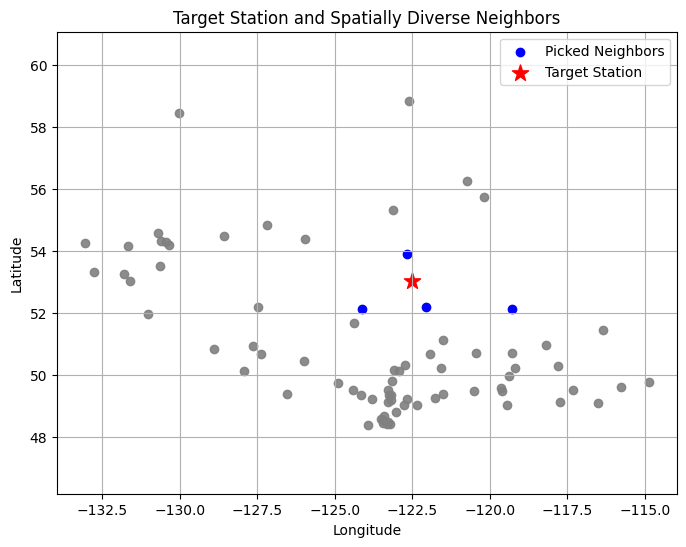

Station PRINCE-GEORGE found in Datasets/CWEEDS_2020_BC\CAN_BC_PRINCE-GEORGE_1096439_CWEEDS2011_1998-2017.csv
Station PUNTZI-MOUNTAIN-(AUT) found in Datasets/CWEEDS_2020_BC\CAN_BC_PUNTZI-MOUNTAIN-(AUT)_1086558_CWEEDS2011_1998-2017.csv
Station WILLIAMS-LAKE-A found in Datasets/CWEEDS_2020_BC\CAN_BC_WILLIAMS-LAKE-A_1098941_CWEEDS2011_1998-2017.csv
Station BLUE-RIVER-CS found in Datasets/CWEEDS_2020_BC\CAN_BC_BLUE-RIVER-CS_1160H99_CWEEDS2011_1998-2017.csv


In [36]:
path = 'Datasets/CWEEDS_2020_BC'
csv_files = glob.glob(os.path.join(path, "*.csv"))

file_path = 'Datasets/stationsName_lat_long_data.csv'
stationsName_lat_long_datadf = pd.read_csv(file_path, delimiter=',', on_bad_lines='skip')
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order, meanGHI1, stdGHI1 = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -122.5, 53, 4, csv_files)
combined_train_chunked_data_tensor = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

In [18]:
dataset = GHIDataset(combined_train_chunked_data_tensor, device=device)#For training
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

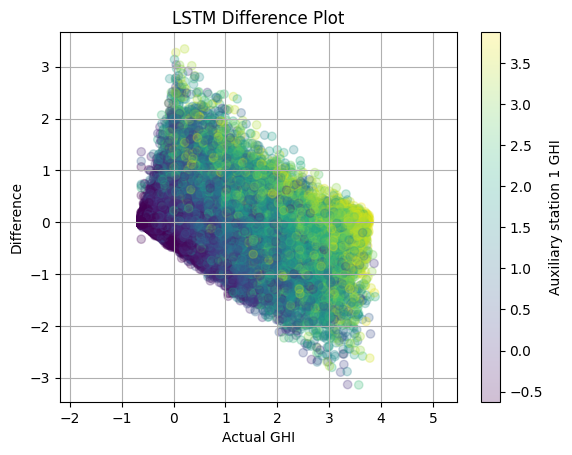

In [19]:
import matplotlib.pyplot as plt
outputlist, targetData, colourList = test_model(mainModel, train_loader, criterion, device)
#mean_MeansGHI = np.mean([meanGHI1, meanGHI2, meanGHI3, meanGHI4, meanGHI5])
#std_MeansGHI = np.mean([stdGHI1, stdGHI2, stdGHI3, stdGHI4, stdGHI5])
targetGHI = targetData#*std_MeansGHI + mean_MeansGHI
outputGHI = outputlist#*std_MeansGHI + mean_MeansGHI #normalized
colourListGHI = colourList[:,0]#*std_MeansGHI + mean_MeansGHI
# angle_rad = np.arcsin(colourList[:,:,6])# 4 For hours. Can also do 6 for months
# angle_deg = np.degrees(angle_rad)
# hour = (angle_deg + 90) * 24 / 180  # Map angle from [-90, 90] to [0, 24]
# month = (angle_deg + 90) * 12 / 180  # Map angle from [-90, 90] to [0, 12]
plt.scatter(targetGHI.flatten(), outputGHI.flatten()-targetGHI.flatten(), c=colourList[:,10].flatten(), alpha=0.25)
#plt.scatter(targetData.flatten(), outputlist.flatten()-targetData.flatten(), c=colourList[:,10].flatten(), alpha=0.25)
plt.axis('equal')
plt.colorbar(label="Auxiliary station 1 GHI")
plt.xlabel('Actual GHI')
plt.ylabel('Difference')
plt.title('LSTM Difference Plot') # from training on ROSE-SPIT-(AUT), WHISTLER---NESTERS, ESQUIMALT-HARBOUR, FORT-NELSON-A and HERBERT-ISLAND-(AUT)
plt.grid()
#plt.savefig("LSTM_Difference_Plot_3_5_1.png")
plt.show()

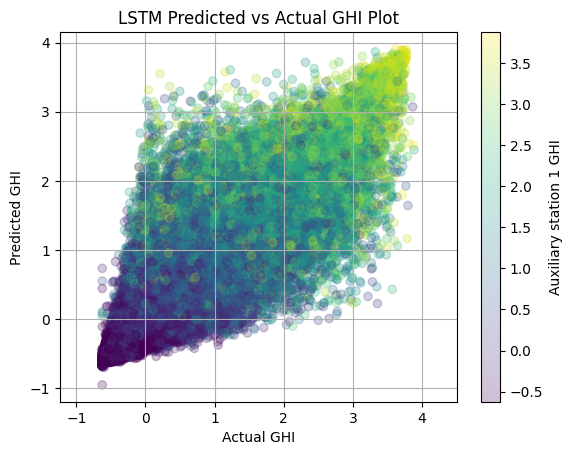

In [22]:
plt.scatter(targetGHI.flatten(), outputGHI.flatten(), c=colourList[:,10].flatten(), alpha=0.25)
#plt.scatter(targetData.flatten(), outputlist.flatten(), c=colourList[:,10].flatten(), alpha=0.25)
plt.axis('equal')
plt.colorbar(label="Auxiliary station 1 GHI")
plt.xlabel('Actual GHI')
plt.ylabel('Predicted GHI')
plt.title('LSTM Predicted vs Actual GHI Plot')# from training on ROSE-SPIT-(AUT), WHISTLER---NESTERS, ESQUIMALT-HARBOUR, FORT-NELSON-A and HERBERT-ISLAND-(AUT)
plt.grid()
#plt.savefig("LSTM_Predicted_vs_Actual_GHI_Plot_3_5_1.png")
plt.show()